In [1]:
from paper_plots import plot_hp_convergence
import numpy as np
from domains import Waveguide, ScattererShape, ScattererType
from FEM_solution import FEM_solution
from Trefft_tools import  TrefftzSpace, AssembleMatrix, AssembleRHS, AssembleBlockRHS, Assemble_blockMatrix

from Trefft_tools import TrefftzFunction
#this should be a "solve system"
from scipy.sparse.linalg import spsolve 


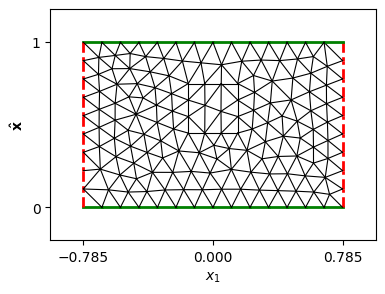

In [63]:
kappa = 8.
R = 2*np.pi/kappa
H = 1.

c = (0,0.6*H)
Domain = Waveguide(R=R,H=H)

rad = 0.3*H
length = rad
width = rad

scatterer_shape = ScattererShape.RECTANGLE
scatterer_type = ScattererType.ABSORBING

# Domain.add_scatterer( ScattererShape.CIRCLE, ScattererType.SOUND_SOFT, (c, rad))
Domain.add_scatterer( scatterer_shape=scatterer_shape, scatterer_type=scatterer_type, params=(c, rad, rad))
# Domain.add_fine_mesh_region(h_min=0.02)

Domain.generate_mesh(h_max=H/9)
Domain.plot_mesh()

In [64]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)
N = 9 + 4j
#N = 9
t = 0
Z = FEM_solution( R=R, H=H, params={"c":c, "height" : length, "width" : width}, scatterer_shape=scatterer_shape, scatterer_type=scatterer_type, 
                 n=t,k_e=kappa,k_i= np.sqrt(N)*kappa, X=X, Y=Y, delta_PML=0.5*R, alpha=0.5*(4+2*1j))

NDOF: 45791


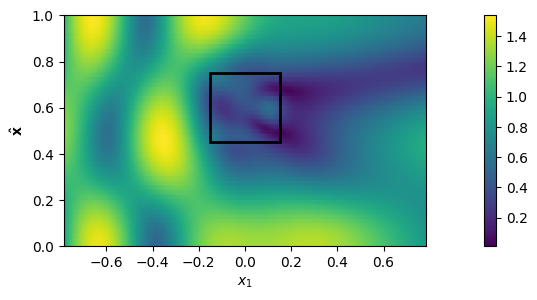

In [65]:
Domain.plot_field(X, Y, np.abs(Z))

In [66]:
Nth = 25
th_0 = np.e/np.pi
th_0 = 0.
V = TrefftzSpace(Domain=Domain, DOF_per_element=Nth, kappa=kappa, n= {"Omega_i" : N, "Omega_e" : 1}, th0=th_0 )
N_modes = 15 #Number of modes for the DtN map
# "UWVF" parameters
a = 0.5
b = 0.5
d_1 = 0.5
d_2 = 0.5
# A_old = AssembleMatrix(V=V, Edges=Domain.Edges, H=H, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
A_block = Assemble_blockMatrix(V=V, Edges=Domain.Edges, th_0=th_0, H=H, k=kappa, N_p=Nth, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes)

NDOF = A_block.shape[0]
print(f'{NDOF} degrees of freedom.\n Matrix with {np.count_nonzero(A_block.toarray())} non-zero entries from a total of {NDOF**2}.\n "fullness" ratio: {np.count_nonzero(A_block.toarray())/NDOF**2 * 100 : .2f}%')

we are in the absorbing case
7050 degrees of freedom.
 Matrix with 764884 non-zero entries from a total of 49702500.
 "fullness" ratio:  1.54%


In [67]:
B = AssembleBlockRHS(V, Domain.Edges, kappa, H, d_2=d_2, t = t)
from Trefft_tools import TrefftzFunction
#this should be a "solve system"
from scipy.sparse.linalg import spsolve 
A = A_block.tocsc()
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

In [68]:
u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])


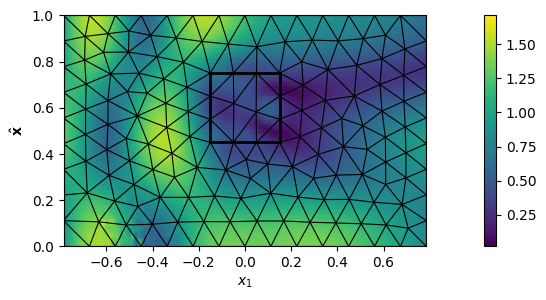

In [69]:
Domain.plot_field(X,Y,np.abs(u_Trefft), show_edges=True)


The relative error is:  2.73e-02


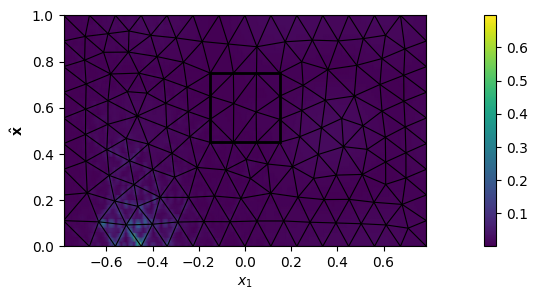

In [70]:
Domain.plot_field(X,Y,np.abs(u_Trefft - Z), show_edges=True)
print(f'The relative error is: {Domain.L2_norm(X,Y,np.abs(u_Trefft - Z))/Domain.L2_norm(X,Y,np.abs(Z)) : .2e}')

NDOF: 61591
working on refinement: N=6
h_max=np.float64(0.3)
Initial refinement:
N_theta=3...
we are in the absorbing case
N_theta=5...
we are in the absorbing case
N_theta=7...
we are in the absorbing case
N_theta=9...
we are in the absorbing case
N_theta=11...
we are in the absorbing case
N_theta=13...
we are in the absorbing case
N_theta=15...
we are in the absorbing case
working on refinement: N=7
h_max=np.float64(0.21284784941388638)
N_theta=3...
we are in the absorbing case
N_theta=5...
we are in the absorbing case
N_theta=7...
we are in the absorbing case
N_theta=9...
we are in the absorbing case
N_theta=11...
we are in the absorbing case
N_theta=13...
we are in the absorbing case
N_theta=15...
we are in the absorbing case
working on refinement: N=8
h_max=np.float64(0.21213203435596428)
N_theta=3...
we are in the absorbing case
N_theta=5...
we are in the absorbing case
N_theta=7...
we are in the absorbing case
N_theta=9...
we are in the absorbing case
N_theta=11...
we are in the

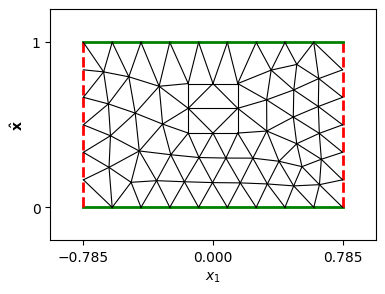

In [15]:
refinements = range(6,13,1)
N_ths = [3,5,7,9,11,13,15]


N_ref = len(refinements)
N_N_th = len(N_ths)

hs = np.zeros((N_ref), dtype=np.float64)
Hs = np.zeros((N_ref), dtype=np.float64)

conds = np.zeros((N_ref,N_N_th), dtype=np.float64)
errors = np.zeros((N_ref,N_N_th), dtype=np.float64)

factor = 8/8

kappa_e = factor*8.
lambda_e = 2*np.pi/kappa_e
R = factor*lambda_e
H = 1.


# c = (-1.5*R,0.3*H)


Ny = 100
Nx = int(R/H*Ny)

x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

t = 0

center = (0, 0.6*H)

height= 0.3*H
width = 0.3*H
N_index = 9 + 4j
u_exact = FEM_solution(R, H, params={"c" : center, "width" : width, "height" : height},
             scatterer_shape=ScattererShape.RECTANGLE, scatterer_type=ScattererType.ABSORBING,
             n = t, k_e=kappa_e, k_i=kappa_e*np.sqrt(N_index), X=X, Y=Y, delta_PML=0.5*R, alpha=(4+2*1j) )


for (i,N) in enumerate(refinements):
    print(f"working on refinement: {N=}")
    h = H/N
    hs[i] = h
   
    Domain = Waveguide(R=R,H=H) 
    Domain.add_scatterer( ScattererShape.RECTANGLE, ScattererType.ABSORBING, (center, height, width))
    
    Domain.generate_mesh(h_max=h)

    side_ls = np.array([E.l for E in Domain.Edges])
    h_max = np.max(side_ls)
    Hs[i] = h_max
    print(f'{h_max=}')

    if i == 0:
        print('Initial refinement:')
        Domain.plot_mesh()

    for (j,Nth) in enumerate(N_ths):
        print(f"N_theta={Nth}...")
        th_0 = 2*np.e/np.pi # no correct direction in the basis
        #th_0 = 0.
        V = TrefftzSpace(Domain, Nth, kappa=kappa_e, n={"Omega_i" : N_index , "Omega_e" : 1}, th0=th_0 )
        N_modes = 15 #Number of modes for the DtN map
        # "UWVF" parameters
        a = 0.5
        b = 0.5
        d_1 = 0.5
        d_2 = 0.5

        A = Assemble_blockMatrix( V=V, Edges=Domain.Edges, H=H, k=kappa_e, N_p = Nth, th_0=th_0, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes)
        B = AssembleBlockRHS(V=V, Edges=Domain.Edges, k=kappa_e, H=H, d_2=d_2, t=t)
        A = A.tocsc()
        
        DOFs = spsolve(A,B)
        f = TrefftzFunction(V,DOFs)

        u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
        errors[i,j] = Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)


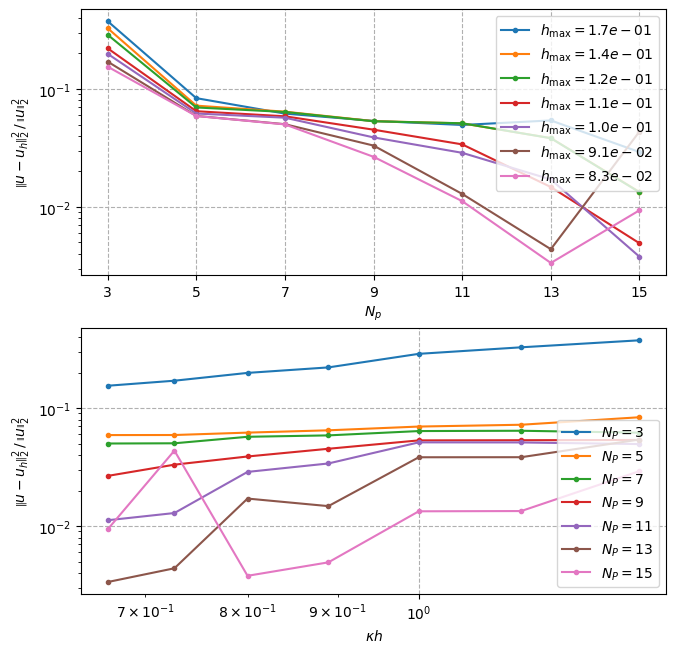

In [19]:
import matplotlib.pyplot as plt
plot_hp_convergence(errors=errors[:,0:], hs=hs, N_ths=N_ths[0:], kappa_e=kappa_e, N_modes=N_modes, H=H)
plt.savefig('hp_convergence_n_9_4j_SAVED.pdf')

In [20]:
np.savez(file='hp_convergence_n_9_4j_SAVED.npz', errors=errors, hs = hs, N_ths=N_ths)

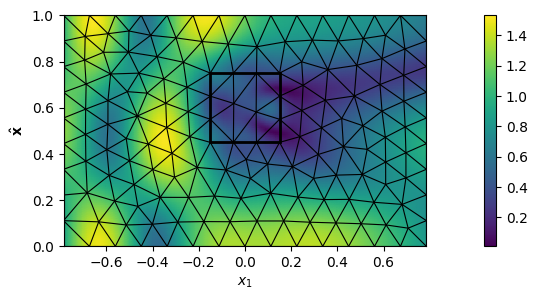

In [10]:
Domain.plot_field(X,Y,np.abs(u_Trefft), show_edges=True)
#plt.savefig('absorbing square.pdf')

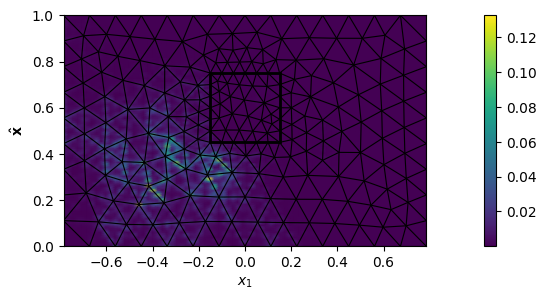

In [5]:
Domain.plot_field(X,Y,np.abs(u_exact - u_Trefft), show_edges=True)


In [7]:
kappa_e = 8.
lambda_e = 2*np.pi/kappa_e
R = lambda_e
H = 1.
center = (0, 0.6*H)

height= 0.3*H
width = 0.3*H

Domain = Waveguide(R=R,H=H) 
Domain.add_scatterer( ScattererShape.RECTANGLE, ScattererType.ABSORBING, (center, height, width))

Domain.generate_mesh(h_max=0.05)


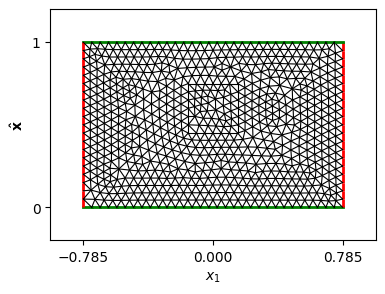

In [8]:
Domain.plot_mesh()

In [93]:
#np.savez(file='hp_convergence_n_9_4j.npz', errors=errors, hs = hs, N_ths=N_ths)

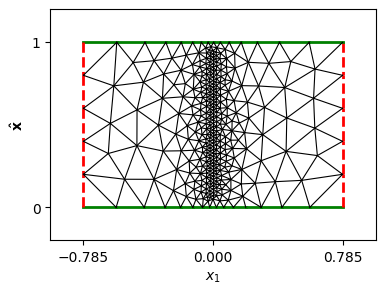

In [78]:
kappa = 8.
R = 2*np.pi/kappa
H = 1.

Domain = Waveguide(R=R,H=H)
Domain.add_fine_mesh_region(h_min=0.02)

Domain.generate_mesh(h_max=H/5)
Domain.plot_mesh()

working on refinement: N=3
h_max=np.float64(0.4067989388936703)
Initial refinement:
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=4
h_max=np.float64(0.3389150489561276)
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=5
h_max=np.float64(0.2898130637277952)
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=6
h_max=np.float64(0.236847643510049)
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=7
h_max=np.float64(0.2030490519562134)
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=8
h_max=np.float64(0.17665355176927594)
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=9
h_max

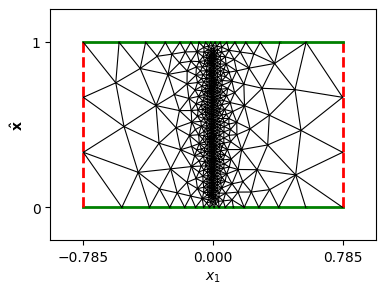

In [2]:
refinements = range(3,10,1)
N_ths = [3,5,7,9,11,13,15]


N_ref = len(refinements)
N_N_th = len(N_ths)

hs = np.zeros((N_ref), dtype=np.float64)
Hs = np.zeros((N_ref), dtype=np.float64)

conds = np.zeros((N_ref,N_N_th), dtype=np.float64)
errors = np.zeros((N_ref,N_N_th), dtype=np.float64)

factor = 8/8

kappa = factor*8.

R = factor*2*np.pi/kappa
H = 1.

Ny = 100
Nx = int(R/H*Ny)

x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

t = 1
beta = np.emath.sqrt(kappa**2 - (t*np.pi/H)**2)
u_exact = np.exp(1j*beta*X)*np.cos(t*np.pi*Y/H)


for (i,N) in enumerate(refinements):
    print(f"working on refinement: {N=}")
    h = H/N
    hs[i] = h
   
    Domain = Waveguide(R=R,H=H) 
    Domain.add_fine_mesh_region(factor = 0.9, h_min = 0.01)

    Domain.generate_mesh(h_max=h)

    side_ls = np.array([E.l for E in Domain.Edges])
    h_max = np.max(side_ls)
    Hs[i] = h_max
    print(f'{h_max=}')

    if i == 0:
        print('Initial refinement:')
        Domain.plot_mesh()

    for (j,Nth) in enumerate(N_ths):
        print(f"N_theta={Nth}...")
        th_0 = np.e/np.pi # no correct direction in the basis
        #th_0 = 0
        V = TrefftzSpace(Domain, Nth, kappa=kappa, n={"Omega_i" : 1 , "Omega_e" : 1}, th0=th_0 )
        N_modes = 15 #Number of modes for the DtN map
        # "UWVF" parameters
        a = 0.5
        b = 0.5
        d_1 = 0.5
        d_2 = 0.5

        A = Assemble_blockMatrix( V=V, Edges=Domain.Edges, H=H, k=kappa, N_p = Nth, th_0=th_0, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes)
        # B = AssembleGreenRHS_left(V = V, Edges=Domain.Edges, k=kappa_e, H=H, d_2=d_2, x_0 = c[0], y_0 = c[1], M = M)
        B = AssembleRHS(V=V, Edges=Domain.Edges, k=kappa, H=H, d_2=1/2, t=t)
        A = A.tocsc()
        
        DOFs = spsolve(A,B)
        f = TrefftzFunction(V,DOFs)

        u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
        errors[i,j] = Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)


In [82]:
import matplotlib.pyplot as plt 

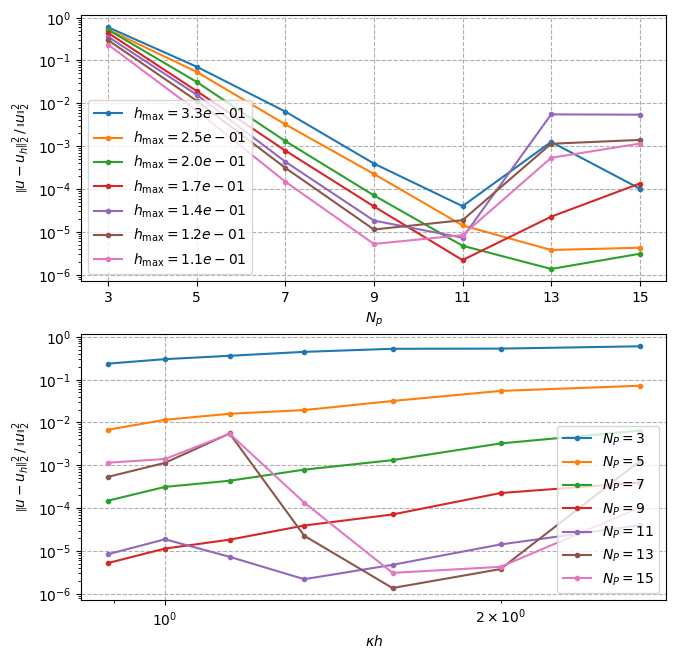

In [83]:
plot_hp_convergence(errors=errors, hs=hs, N_ths=N_ths, kappa_e=kappa, N_modes=N_modes, H=H)
# plt.savefig('fine_barrier_raw.png')

In [84]:
# np.savez(file='fine_barrier_raw.npz', errors=errors, hs = hs, N_ths=N_ths)